<a href="https://colab.research.google.com/github/andresdevml/dl_writing_quality/blob/main/data_experimentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Exportamos librerias de interes**

In [1]:
import numpy as np

import pandas as pd

from sklearn.linear_model import Ridge

from sklearn import svm

from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import make_pipeline

import tensorflow as tf

import matplotlib.pyplot as plt

from scipy import interpolate

from google.colab import drive



# **Importamos la data**

In [2]:
# conectamos al drive
drive.mount('/content/drive')

# Definimos el directorio
dir_data_kaggle='./drive/MyDrive/lwpwq/data'


# extraemos la data

df_train_logs=pd.read_csv(filepath_or_buffer=dir_data_kaggle+'/train_logs.csv')

df_train_scores=pd.read_csv(filepath_or_buffer=dir_data_kaggle+'/train_scores.csv')

Mounted at /content/drive


In [3]:
# observemos las columnas presentes

df_train_logs.columns

Index(['id', 'event_id', 'down_time', 'up_time', 'action_time', 'activity',
       'down_event', 'up_event', 'text_change', 'cursor_position',
       'word_count'],
      dtype='object')

# **Feature Enginering**

**crearemos las caracteristicas una a una de manera manual, el data set sera un diccionario**


In [26]:
# primero hacemos el trabajo sobre todas las caractetisticas de una sola serie


id=df_train_logs['id'].unique()[100]


df_data=df_train_logs[df_train_logs['id']==id]



In [50]:
# action_time


action_time=df_data['action_time']

action_time=(((action_time-action_time.mean())/action_time.std()).values).reshape(-1,1)


# delay

up_time_displaced=pd.concat(
                              objs=[  pd.Series([0]) ,   df_data['up_time']  ],
                              ignore_index=True)

delay_time=(df_data['down_time'].values-up_time_displaced.iloc[0:-1].values)


delay_time=((delay_time-delay_time.mean())/delay_time.std()).reshape(-1,1)


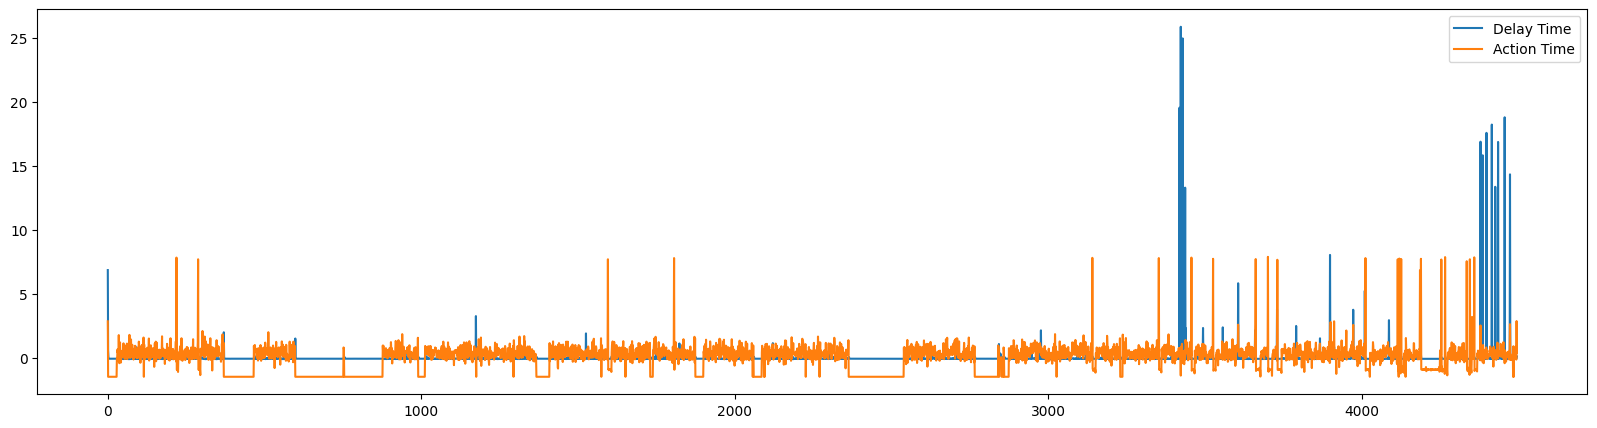

In [51]:
# grafiquemos para ver

plt.figure(figsize=(20,5))
plt.plot(delay_time, label='Delay Time')
plt.plot(action_time, label='Action Time')
plt.legend()
plt.show()


In [7]:
# activity

vocab_cut=df_train_logs['activity'].apply(lambda x: x[:3])

activity_cut=df_data['activity'].apply(lambda x: x[:3])

# veamos las categorias resultnates

vocab_cut.unique()

array(['Non', 'Inp', 'Rem', 'Rep', 'Mov', 'Pas'], dtype=object)

In [57]:
# aplicamos la categorizacion


layer_cat_act= tf.keras.layers.StringLookup(vocabulary=vocab_cut.unique(),
                                            num_oov_indices=1,
                                            output_mode='one_hot')

activity_cat=np.array(layer_cat_act(activity_cut))

print(activity_cat)

[[0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]


In [53]:
activity_cat.shape

TensorShape([4495, 7])

In [9]:
# mod_activity


def mod_act(str_arr):
  if str_arr=='NoChange':

    return 0

  else:

    if ' => ' in str_arr:

      str_split=str_arr.split(' => ', maxsplit=1)

      return len(str_split[0])+len(str_split[1])

    else:

      return len(str_arr)

mod_activity=df_data['text_change'].apply(mod_act)


In [10]:
# up_event and down_event

vocab_event=(pd.concat(objs=[df_train_logs['up_event'],df_train_logs['up_event']],axis=0,ignore_index=True)).unique()


layer_cat_event= tf.keras.layers.StringLookup(vocabulary=vocab_event,
                                            num_oov_indices=1,
                                            output_mode='one_hot')


down_event_cat=layer_cat_act(df_data['down_event'])

up_event_cat=layer_cat_act(df_data['up_event'])

In [11]:
# cursor position

aux_ts=df_data['cursor_position']

cursor_position=((aux_ts-aux_ts.mean())/(aux_ts.std())).values

# provemos el svr

regr_cp = make_pipeline(StandardScaler(), svm.SVR(kernel='linear',C=5, epsilon=10e-12))

regr_cp.fit(
    np.arange(len(cursor_position)).reshape(-1,1),
    cursor_position.reshape(-1,1))

cursor_position_lin=regr_cp.predict(
                                  np.arange(
                                                  len(cursor_position)
                                                            ).reshape(-1,1)
                                                                  )


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


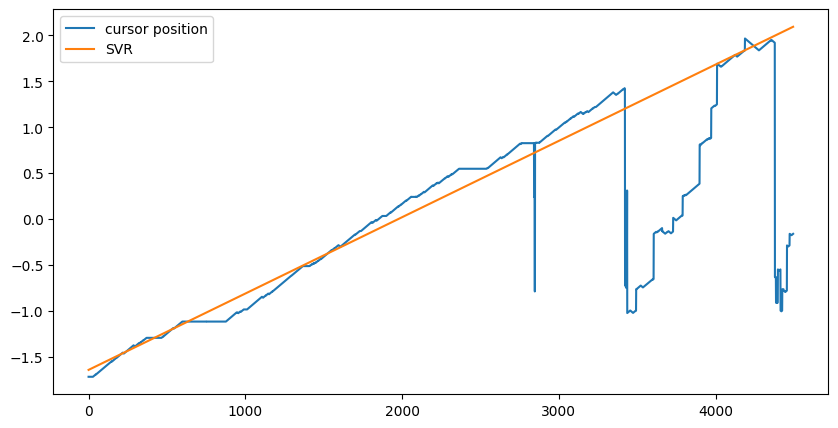

In [12]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(len(cursor_position)),cursor_position, label='cursor position')
plt.plot(np.arange(len(cursor_position)),cursor_position_lin, label='SVR')
plt.legend()
plt.show()

In [30]:
# cursor_position_feat


cursor_position_flat=((-1)*(cursor_position-cursor_position_lin)).reshape(-1,1)

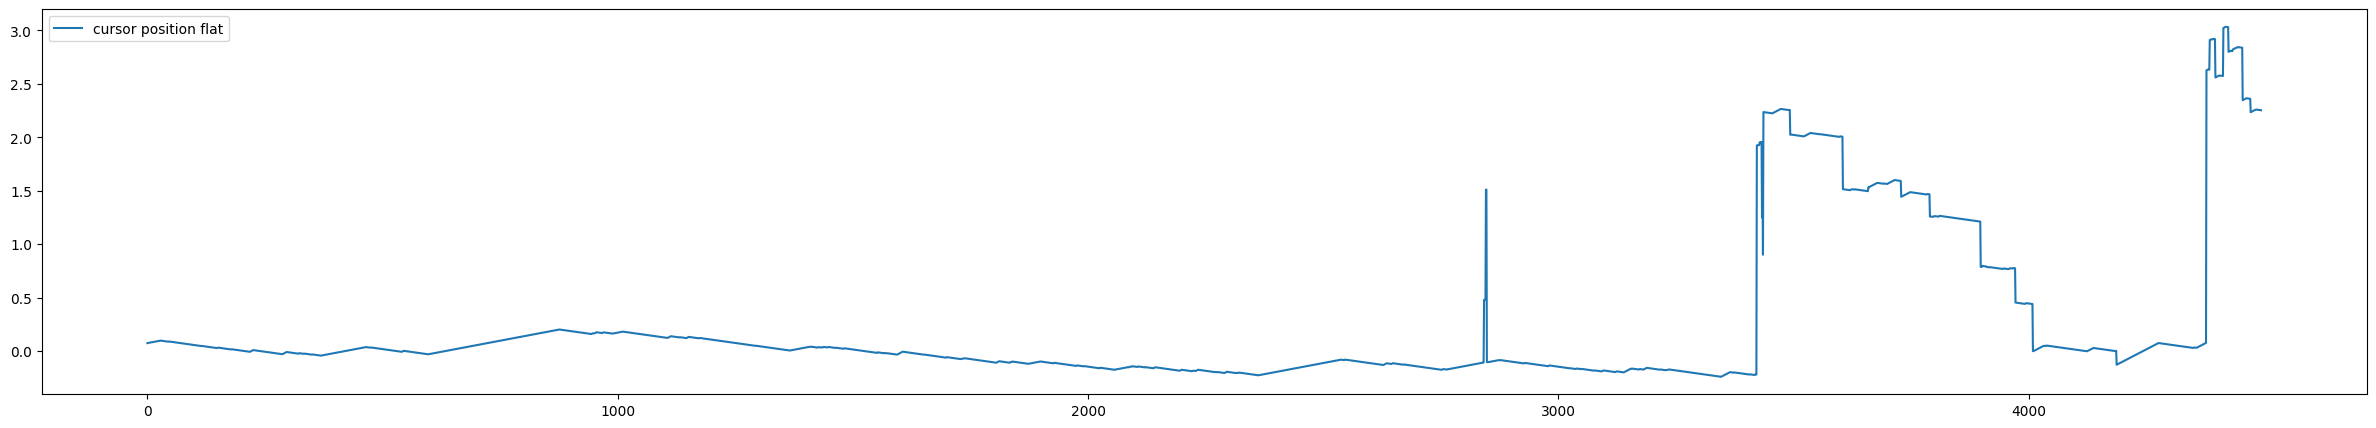

In [31]:
# establecemos la caracteristica sin la tendencia lineal


plt.figure(figsize=(30,5))
plt.plot(np.arange(len(cursor_position)),cursor_position_flat, label='cursor position flat')
plt.legend()
plt.show()

In [15]:

# aplicamos el mismo procedimiento anterior para word count

# word count

aux_ts=df_data['word_count']

word_count=((aux_ts-aux_ts.mean())/(aux_ts.std())).values


# provemos el svr

regr_wc = make_pipeline(StandardScaler(), svm.SVR(kernel='linear',C=5, epsilon=10e-12))

regr_wc.fit(
    np.arange(len(word_count)).reshape(-1,1),
    word_count.reshape(-1,1))

word_count_lin=regr_wc.predict(
                                  np.arange(
                                                  len(word_count)
                                                            ).reshape(-1,1)
                                                                  )


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


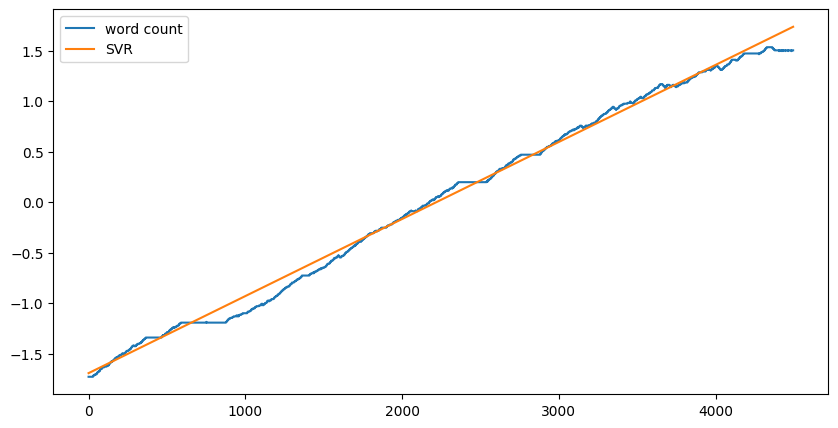

In [16]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(len(word_count)),word_count, label='word count')
plt.plot(np.arange(len(word_count)),word_count_lin, label='SVR')
plt.legend()
plt.show()

In [62]:

word_count_flat=((-1)*(word_count-word_count_lin)).reshape(-1,1)


# hacemos una interpolacion

x_dense=np.arange(len(cursor_position))


index_interp=np.floor(np.linspace(x_dense[0], x_dense[-1] ,int(len(x_dense)*0.02))).astype(int)

x=x_dense[index_interp]

y=np.squeeze(word_count_flat[index_interp])

f = interpolate.interp1d(x, y,'linear')

word_count_flat_intp=f(np.arange(len(cursor_position))).reshape(-1,1)

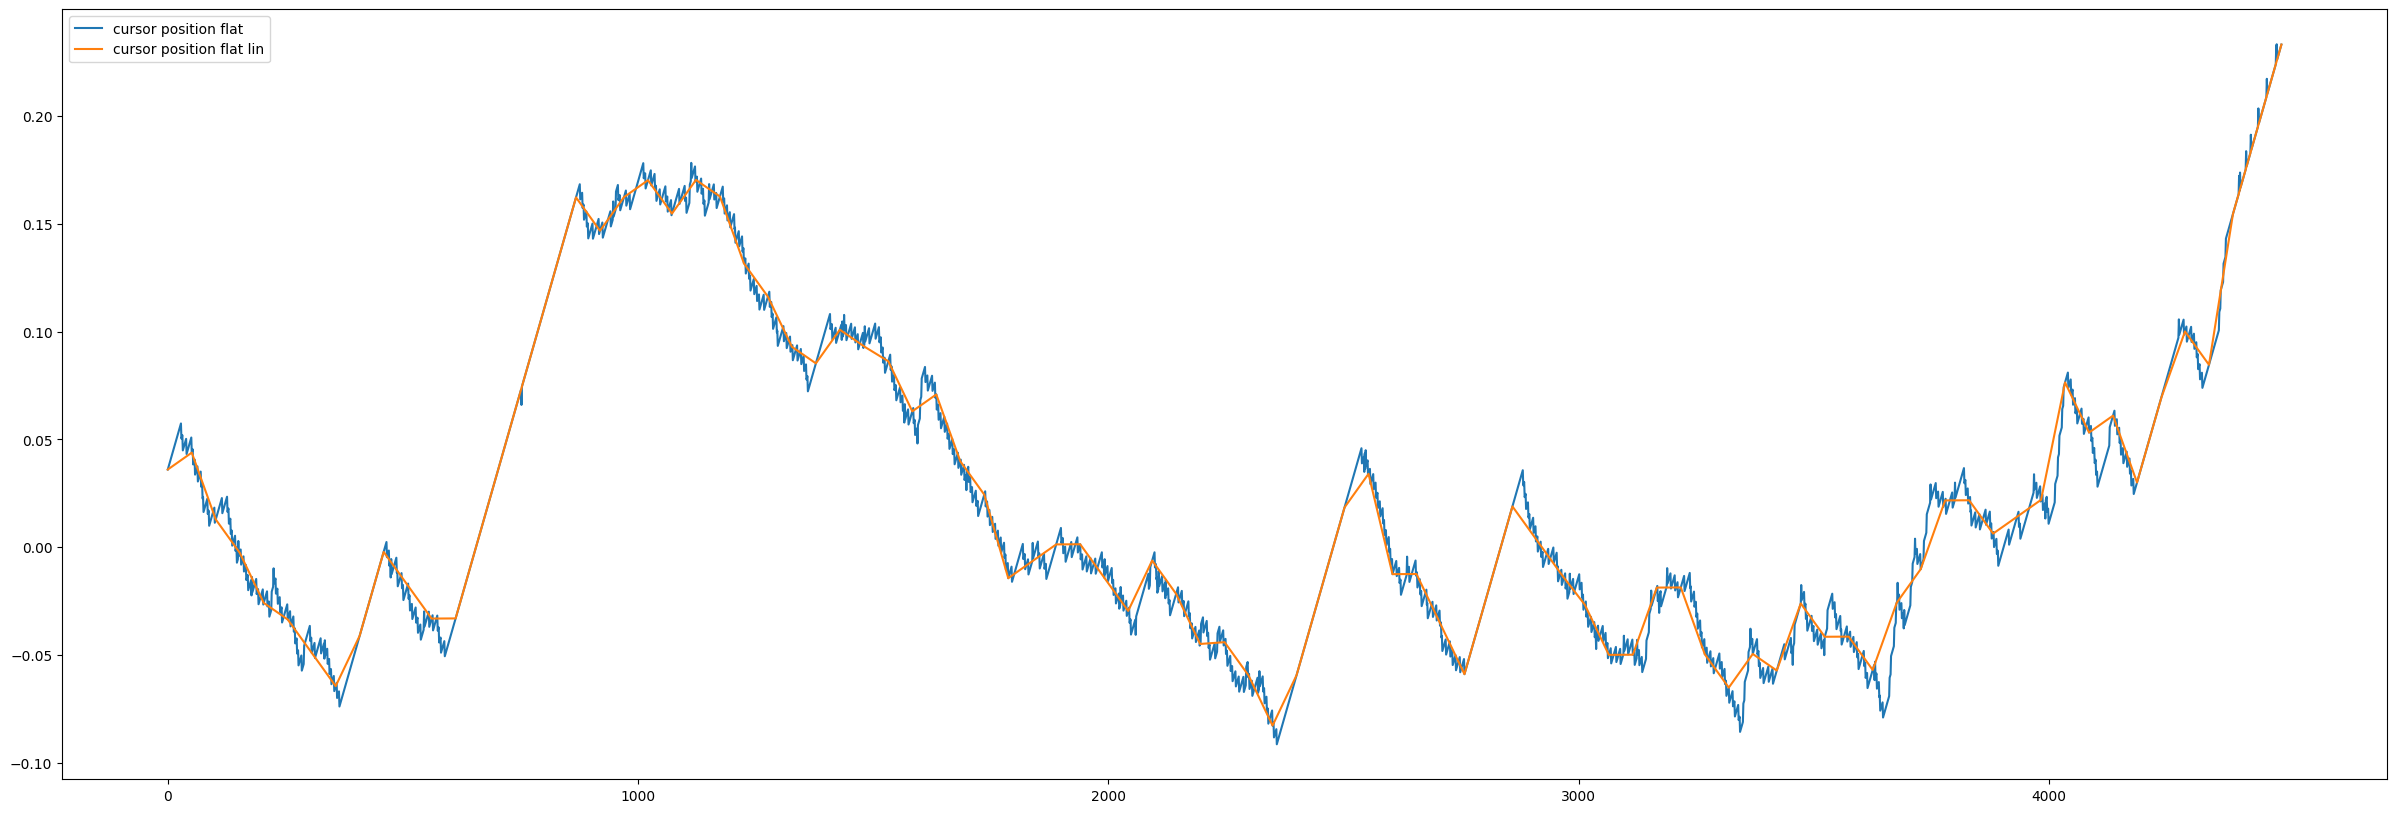

In [64]:
# establecemos la caracteristica sin la tendencia lineal


plt.figure(figsize=(30,10))
plt.plot(x_dense,word_count_flat, label='cursor position flat')
plt.plot(x_dense,word_count_flat_intp, label='cursor position flat lin')
plt.legend()

plt.show()

In [19]:

# change text

# definimos una funcion de transformacion

def text_change_format(pd_serie):

  aux_serie=pd_serie.copy(deep=True)
  for row,value in enumerate(aux_serie):
    if ' => ' in value:
      aux_serie.iloc[row]='=>'
  return aux_serie

# aplicamos la funcion de transformacion

tc_transf=text_change_format(df_train_logs['text_change'])

tc_transf.value_counts(normalize=True)[:25]*100


q           72.903668
            16.379321
NoChange     8.373299
.            0.806541
,            0.651888
\n           0.332826
'            0.156937
"            0.055425
-            0.053439
=>           0.052915
?            0.041721
;            0.034559
=            0.027219
/            0.016108
\            0.013086
:            0.009672
(            0.008720
[            0.008625
)            0.007852
!            0.007602
>            0.002106
]            0.001868
.            0.001630
$            0.001332
*            0.001285
Name: text_change, dtype: float64

In [92]:
# Definimos la capa

vocab_tc=tc_transf.value_counts(normalize=True)[:25].index.to_numpy()

layer_tc= tf.keras.layers.StringLookup(vocabulary=vocab_tc,
                                            num_oov_indices=1,
                                                  output_mode='int')



# aplicamos la transformacion como si fuera la primera vez xd


tc_feat=np.array( (layer_tc(text_change_format(df_data['text_change']))+1)/12).reshape(-1,1)

In [93]:
np.unique(tc_feat)

array([0.08333333, 0.16666667, 0.25      , 0.33333333, 0.41666667,
       0.5       , 0.58333333, 0.66666667, 0.83333333, 0.91666667,
       1.08333333])

# **caracteristicas estaticas**



In [44]:
len_time=np.maximum(df_data['up_time'].max(),df_data['down_time'].max())/np.maximum(df_train_logs['up_time'].max(),df_train_logs['down_time'].max())
print(len_time)

0.21040277219295797


In [45]:
len_word=df_data['word_count'].max()/df_train_logs['word_count'].max()
print(len_word)

0.3167420814479638


In [46]:
len_cursor_position=df_data['cursor_position'].max()/df_train_logs['cursor_position'].max()
print(len_cursor_position)

0.3251730325557549


# **Armamos el dicionario**

In [27]:
# veamos la data

print(id)

0a21bbd6


In [55]:
# veamos las dimensiones

delay_time.shape

(4495, 1)

In [56]:
action_time.shape

(4495, 1)

In [71]:
activity_cat.shape

(4495, 7)

In [72]:
cursor_position_flat.shape

(4495, 1)

In [65]:
word_count_flat_intp.shape

(4495, 1)

In [69]:
tc_feat.shape

(4495, 1)

In [88]:
# concatenamos la data

dyn_data=np.hstack(
                      tup=(   delay_time,
                              action_time,
                              activity_cat,
                              cursor_position_flat,
                              word_count_flat_intp,
                              tc_feat     )
                                                  )


stat_data=np.hstack(

                          tup=(len_time,len_word,len_cursor_position)

                              )

target=df_train_scores[df_train_scores['id']==id]['score'].values

In [89]:
train_data_example={

    '0a21bbd6':

     {
        'dyn_data':dyn_data,
        'stat_data':stat_data,
        'target':target
                              }
                                      }

In [90]:
train_data_example

{'0a21bbd6': {'dyn_data': array([[ 6.85430478,  2.84548166,  0.        , ...,  0.07495391,
           0.03603343,  0.25      ],
         [ 0.56287418, -1.49591602,  0.        , ...,  0.07578488,
           0.03618719,  0.25      ],
         [ 0.05192915, -1.49591602,  0.        , ...,  0.07661585,
           0.03634095,  0.25      ],
         ...,
         [-0.08391387, -0.14989316,  0.        , ...,  2.25479297,
           0.23174815,  0.08333333],
         [-0.06229584,  2.86443973,  0.        , ...,  2.25417266,
           0.23251147,  0.08333333],
         [ 0.0942888 ,  0.39989083,  0.        , ...,  2.25355235,
           0.23327479,  0.08333333]]),
  'stat_data': array([0.21040277, 0.31674208, 0.32517303]),
  'target': array([4.5])}}